In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

In [ ]:
def preprocess_data(df, selected_features, log_transform_features=None, one_hot_encode=False):
    X = df[selected_features].copy()
    
    if log_transform_features is None:
        log_transform_features = {
            'age_mean_mass': False,
            'velDisp_ppxf_res': False,
            '[M/H]_mean_mass': False
        }

    for feature, do_log in log_transform_features.items():
        if do_log and feature in X.columns:
            X[feature] = np.log10(X[feature] + 1e-10)
    
    return X, X.columns.tolist()

In [ ]:
df = pd.read_csv('../data/E-INSPIRE_I_master_catalogue.csv')
selected_features = ['MgFe', '[M/H]_mean_mass', 'velDisp_ppxf_res', 'age_mean_mass']

log_transform_config = {
    'age_mean_mass': False,
    'velDisp_ppxf_res': False,
    'MgFe': False,
    '[M/H]_mean_mass': False
}

# Preprocess data
X, feature_names = preprocess_data(
    df, 
    selected_features, 
    log_transform_features=log_transform_config,
)
y = df['DoR'].values

In [ ]:
def jitter_data(X, y, jitter_factor=0.03, n_samples=2):
    """Create jittered versions of data, focusing on extreme values."""
    low_threshold = np.percentile(y, 15)
    high_threshold = np.percentile(y, 85)
    extreme_mask = (y <= low_threshold) | (y >= high_threshold)
    
    X_extreme = X[extreme_mask]
    y_extreme = y[extreme_mask]
    
    X_aug_list = [X]
    y_aug_list = [y]
    
    for i in range(n_samples):
        noise_X = np.random.normal(0, jitter_factor * X_extreme.std(axis=0), X_extreme.shape)
        X_jittered = X_extreme + noise_X
        
        noise_y = np.random.normal(0, jitter_factor * y_extreme.std() * 0.5, y_extreme.shape)
        y_jittered = y_extreme + noise_y
        
        X_aug_list.append(X_jittered)
        y_aug_list.append(y_jittered)
    
    X_augmented = np.vstack(X_aug_list)
    y_augmented = np.concatenate(y_aug_list)
    
    return X_augmented, y_augmented

def custom_extremes_loss(y_true, y_pred):
    mse = tf.keras.backend.square(y_true - y_pred)
    weights = 1 + 2 * tf.keras.backend.abs(y_true - tf.keras.backend.mean(y_true))
    return tf.keras.backend.mean(mse * weights)

# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create jittered data and combine
#X_train_scaled, y_train = jitter_data(X_train_scaled, y_train)

# Build model
input_dim = X_train_scaled.shape[1]  # Account for potential one-hot encoding

model = Sequential([
    Dense(16, activation='relu', input_shape=(input_dim,), kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(12, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(8, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='linear')
])

# Compile
model.compile(
    optimizer='adam',
    loss=custom_extremes_loss,
    weighted_metrics=['mse']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

# Fit
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate
y_pred_nn = model.predict(X_test_scaled)
print("\nTest Set Performance:")
print(f"R² Score: {r2_score(y_test, y_pred_nn):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_nn)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_nn):.4f}")


X_full = df[selected_features]

X_full_scaled = scaler.fit_transform(X_full)
y_full_pred = model.predict(X_full_scaled)

print("\nFull Dataset Performance:")
print(f"R² Score: {r2_score(y, y_full_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y, y_full_pred)):.4f}")
print(f"MAE: {mean_absolute_error(y, y_full_pred):.4f}")

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values')
plt.grid(True)
plt.show()

In [ ]:
# Create a scatter plot of all predictions vs actual values
plt.figure(figsize=(12, 8))

# Plot all data points
plt.scatter(y, y_full_pred, alpha=0.5)

# Add the diagonal line for reference
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--', label='Perfect Prediction')

# Add labels and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs True Values (Full Dataset)')

# Add grid and legend
plt.grid(True, alpha=0.3)
plt.legend()

# Optional: Add text box with metrics
metrics_text = f'R² Score: {r2_score(y, y_full_pred):.4f}\nRMSE: {np.sqrt(mean_squared_error(y, y_full_pred)):.4f}\nMAE: {mean_absolute_error(y, y_full_pred):.4f}'
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top')

plt.tight_layout()
plt.show()

Epoch [10/500], Train Loss: 0.1389, Val Loss: 0.1512
Epoch [20/500], Train Loss: 0.0971, Val Loss: 0.0945
Epoch [30/500], Train Loss: 0.0830, Val Loss: 0.0828
Epoch [40/500], Train Loss: 0.0752, Val Loss: 0.0753
Epoch [50/500], Train Loss: 0.0698, Val Loss: 0.0688
Epoch [60/500], Train Loss: 0.0636, Val Loss: 0.0629
Epoch [70/500], Train Loss: 0.0580, Val Loss: 0.0580
Epoch [80/500], Train Loss: 0.0544, Val Loss: 0.0540
Epoch [90/500], Train Loss: 0.0506, Val Loss: 0.0515
Epoch [100/500], Train Loss: 0.0482, Val Loss: 0.0494
Epoch [110/500], Train Loss: 0.0469, Val Loss: 0.0482
Epoch [120/500], Train Loss: 0.0460, Val Loss: 0.0475
Epoch [130/500], Train Loss: 0.0460, Val Loss: 0.0465
Epoch [140/500], Train Loss: 0.0451, Val Loss: 0.0458
Epoch [150/500], Train Loss: 0.0442, Val Loss: 0.0453
Epoch [160/500], Train Loss: 0.0446, Val Loss: 0.0447
Epoch [170/500], Train Loss: 0.0436, Val Loss: 0.0444
Epoch [180/500], Train Loss: 0.0429, Val Loss: 0.0440
Epoch [190/500], Train Loss: 0.0428, 

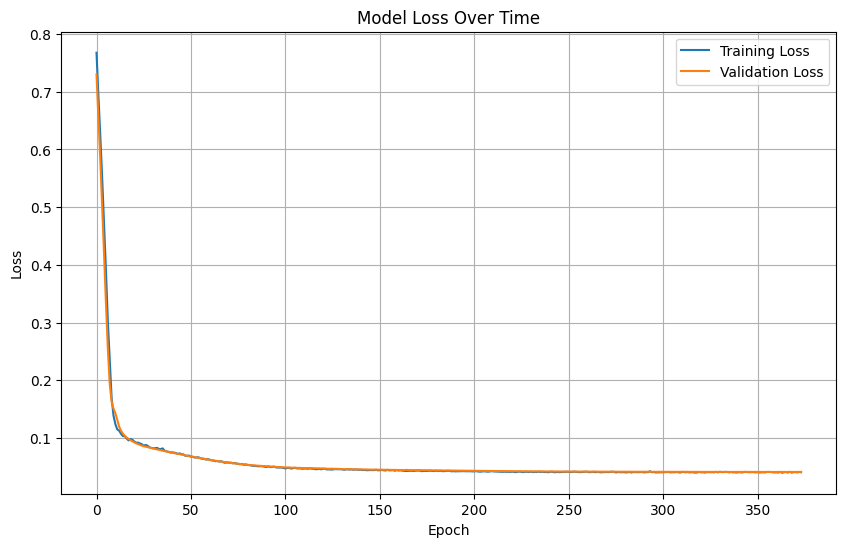


Test Set Performance:
R² Score: 0.7815
RMSE: 0.0759
MAE: 0.0561

Full Dataset Performance:
R² Score: 0.7654
RMSE: 0.0724
MAE: 0.0529


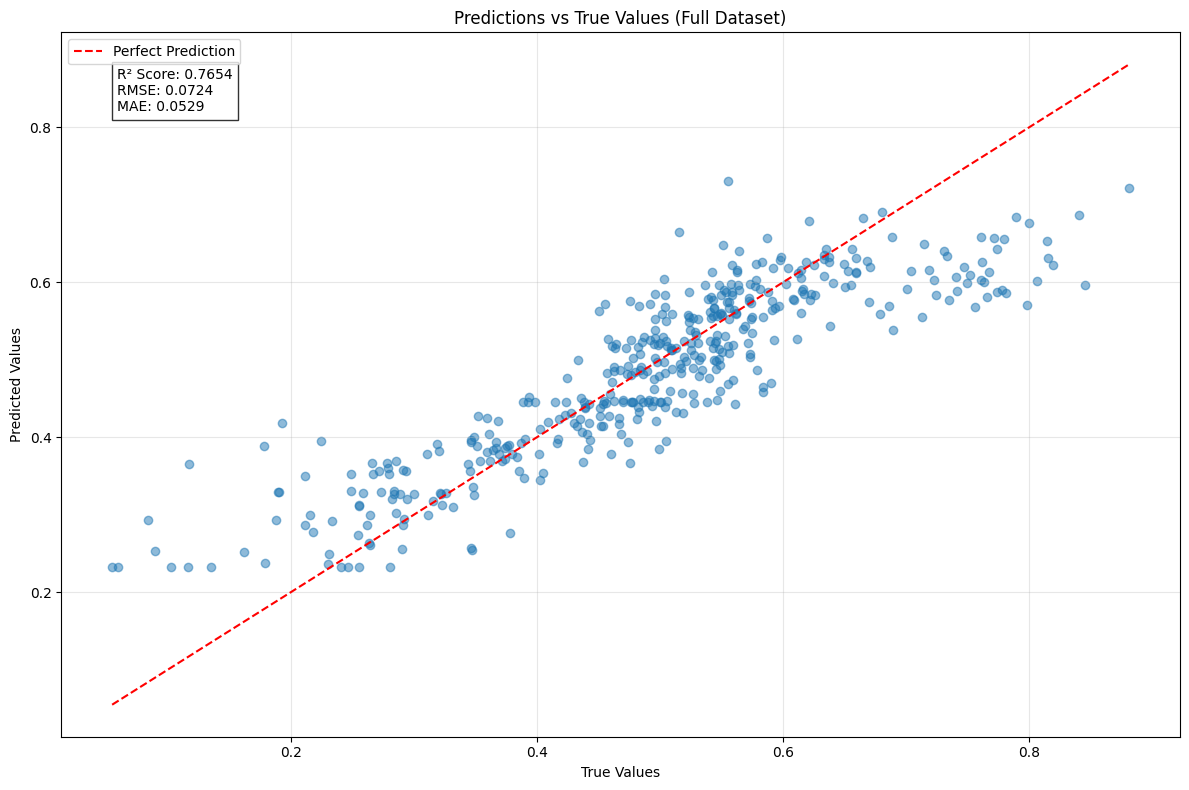

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def preprocess_data(df, selected_features, log_transform_features=None):
    X = df[selected_features].copy()
    
    if log_transform_features is None:
        log_transform_features = {
            'age_mean_mass': False,
            'velDisp_ppxf_res': False,
            '[M/H]_mean_mass': False
        }

    for feature, do_log in log_transform_features.items():
        if do_log and feature in X.columns:
            X[feature] = np.log10(X[feature] + 1e-10)
    
    return X, X.columns.tolist()

class CustomExtremesLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, y_pred, y_true):
        mse = torch.square(y_true - y_pred)
        weights = 1 + 2 * torch.abs(y_true - torch.mean(y_true))
        return torch.mean(mse * weights)

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 12),
            nn.ReLU(),
            nn.Linear(12, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
        
        # Add L2 regularization
        self.l2_lambda = 0.01
        
    def forward(self, x):
        return self.layers(x)
        
    def get_l2_loss(self):
        l2_loss = 0
        for param in self.parameters():
            l2_loss += torch.norm(param, p=2)
        return self.l2_lambda * l2_loss

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=500, patience=20):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch) + model.get_l2_loss()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch) + model.get_l2_loss()
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            model.load_state_dict(best_model_state)
            break
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return train_losses, val_losses

def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("device:", device)
    # Load and preprocess data
    df = pd.read_csv('../data/E-INSPIRE_I_master_catalogue.csv')
    selected_features = ['MgFe', '[M/H]_mean_mass', 'velDisp_ppxf_res', 'age_mean_mass']
    
    log_transform_config = {
        'age_mean_mass': False,
        'velDisp_ppxf_res': False,
        'MgFe': False,
        '[M/H]_mean_mass': False
    }
    
    X, feature_names = preprocess_data(df, selected_features, log_transform_config)
    y = df['DoR'].values
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)
    
    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    val_loader = DataLoader(val_dataset, batch_size=32)
    
    # Initialize model
    input_dim = X_train_scaled.shape[1]
    model = NeuralNetwork(input_dim).to(device)
    
    # Define loss and optimizer
    criterion = CustomExtremesLoss()
    optimizer = optim.Adam(model.parameters())
    
    # Train model
    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, device)
    
    # Plot learning curves
    """plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Model Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()"""
    
    # Evaluate model
    model.eval()
    with torch.no_grad():
        y_pred_nn = model(X_test_tensor.to(device)).cpu().numpy()
        
    """print("\nTest Set Performance:")
    print(f"R² Score: {r2_score(y_test, y_pred_nn):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_nn)):.4f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred_nn):.4f}")
    
    # Full dataset evaluation
    X_full = df[selected_features]
    X_full_scaled = scaler.fit_transform(X_full)
    X_full_tensor = torch.FloatTensor(X_full_scaled)
    
    with torch.no_grad():
        y_full_pred = model(X_full_tensor.to(device)).cpu().numpy()
    
    print("\nFull Dataset Performance:")
    print(f"R² Score: {r2_score(y, y_full_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y, y_full_pred)):.4f}")
    print(f"MAE: {mean_absolute_error(y, y_full_pred):.4f}")
    
    # Plot predictions vs actual
    plt.figure(figsize=(12, 8))
    plt.scatter(y, y_full_pred, alpha=0.5)
    plt.plot([min(y), max(y)], [min(y), max(y)], 'r--', label='Perfect Prediction')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Predictions vs True Values (Full Dataset)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add metrics text box
    metrics_text = f'R² Score: {r2_score(y, y_full_pred):.4f}\nRMSE: {np.sqrt(mean_squared_error(y, y_full_pred)):.4f}\nMAE: {mean_absolute_error(y, y_full_pred):.4f}'
    plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top')
    
    plt.tight_layout()
    plt.show()"""

main()